In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv("Bengaluru_House_Data.csv")  # replace with your actual file name


In [2]:
print(df.columns)


Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price'],
      dtype='object')


In [3]:
# Drop society only if it exists
if 'society' in df.columns:
    df.drop('society', axis=1, inplace=True)


In [4]:
# Fill missing values with most frequent values (mode) if available

if 'location' in df.columns and not df['location'].mode().empty:
    df['location'].fillna(df['location'].mode()[0], inplace=True)

if 'size' in df.columns and not df['size'].mode().empty:
    df['size'].fillna(df['size'].mode()[0], inplace=True)

if 'availability' in df.columns and not df['availability'].mode().empty:
    df['availability'].fillna(df['availability'].mode()[0], inplace=True)


C:\Users\hp\AppData\Local\Temp\ipykernel_14324\2593852665.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['location'].fillna(df['location'].mode()[0], inplace=True)
C:\Users\hp\AppData\Local\Temp\ipykernel_14324\2593852665.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.



In [5]:
# Numerical values — use median (robust to outliers)
if 'bath' in df.columns:
    df['bath'].fillna(df['bath'].median(), inplace=True)

if 'balcony' in df.columns:
    df['balcony'].fillna(df['balcony'].median(), inplace=True)


C:\Users\hp\AppData\Local\Temp\ipykernel_14324\1462651299.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['bath'].fillna(df['bath'].median(), inplace=True)
C:\Users\hp\AppData\Local\Temp\ipykernel_14324\1462651299.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For examp

In [6]:
# Extract numeric value from 'size' column (e.g., "2 BHK" → 2)
df['size'] = df['size'].str.extract('(\d+)').astype(float)


<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\hp\AppData\Local\Temp\ipykernel_14324\2288767260.py:2: SyntaxWarning: invalid escape sequence '\d'
  df['size'] = df['size'].str.extract('(\d+)').astype(float)


In [7]:
# Convert 'total_sqft' values to float
def convert_sqft(value):
    try:
        # If range, return average
        if '-' in str(value):
            tokens = value.split('-')
            return (float(tokens[0]) + float(tokens[1])) / 2
        # If it can be directly converted to float
        return float(value)
    except:
        return None  # Skip complex formats like '34.5Sq. Meter'

df['total_sqft'] = df['total_sqft'].apply(convert_sqft)


In [8]:
# Drop rows where total_sqft is still None after conversion
df.dropna(subset=['total_sqft'], inplace=True)


💬 Why Label Encoding?
Each unique category gets a number (e.g., Whitefield → 157)

Unlike one-hot, it doesn’t blow up the number of features (especially helpful for location, which has 200+ values).

Random Forest is tree-based, so label encoding won't hurt the performance like it would in linear models.

In [9]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoders for each column
le_area = LabelEncoder()
le_avail = LabelEncoder()
le_loc = LabelEncoder()

# Apply encoding
df['area_type'] = le_area.fit_transform(df['area_type'])
df['availability'] = le_avail.fit_transform(df['availability'])
df['location'] = le_loc.fit_transform(df['location'])


In [10]:
import numpy as np

# outlier removing

# Calculate Q1 and Q3
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

# Identify outliers
df_no_outliers = df[(df['price'] >= (Q1 - 1.5 * IQR)) & (df['price'] <= (Q3 + 1.5 * IQR))]

df.reset_index(drop=True, inplace=True)

print(df_no_outliers)

       area_type  availability  location  size  total_sqft  bath  balcony  \
0              3            40       416   2.0      1056.0   2.0      1.0   
1              2            80       314   4.0      2600.0   5.0      3.0   
2              0            80      1174   3.0      1440.0   2.0      3.0   
3              3            80       754   3.0      1521.0   3.0      1.0   
4              3            80       713   2.0      1200.0   2.0      1.0   
...          ...           ...       ...   ...         ...   ...      ...   
13312          3            80       234   2.0      1262.0   2.0      2.0   
13313          3            80      1174   3.0      1345.0   2.0      1.0   
13314          3            80       471   3.0      1715.0   3.0      3.0   
13317          0            80       967   2.0      1141.0   2.0      1.0   
13319          3            80       393   1.0       550.0   1.0      1.0   

        price  
0       39.07  
1      120.00  
2       62.00  
3       95.

In [11]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_limit) & (df[column] <= upper_limit)]


In [12]:
# List of all numerical columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Apply outlier removal for each numerical column
for col in num_cols:
    df = remove_outliers_iqr(df, col)


In [13]:
# Remove top and bottom 1% of price to reduce noise
q1 = df['price'].quantile(0.01)
q99 = df['price'].quantile(0.99)
df = df[(df['price'] > q1) & (df['price'] < q99)]


In [14]:
# Remove rows where sqft per BHK is suspiciously low or high
df = df[df['size'] > 0]  # avoid division by zero
df['sqft_per_bhk'] = df['total_sqft'] / df['size']
df = df[(df['sqft_per_bhk'] > 300) & (df['sqft_per_bhk'] < 2000)]


In [15]:
# Group rare locations into 'Other'
location_counts = df['location'].value_counts()
rare_locations = location_counts[location_counts <= 10].index
df['location'] = df['location'].apply(lambda x: 'Other' if x in rare_locations else x)


In [16]:
# Convert all location values to string
df['location'] = df['location'].astype(str)

# Now safely encode
from sklearn.preprocessing import LabelEncoder
le_loc = LabelEncoder()
df['location'] = le_loc.fit_transform(df['location'])


In [17]:
# Only select numerical columns
num_cols = ['total_sqft', 'size', 'bath', 'balcony', 'price']

# Show skewness
df[num_cols].skew()


total_sqft    0.466040
size          0.029635
bath          0.574612
balcony       0.024465
price         0.864479
dtype: float64

In [18]:
import numpy as np

# Apply log1p to reduce skewness
df[['total_sqft','area_type']] = np.log1p(df[['total_sqft','area_type']])
df['price'] = np.log1p(df['price'])   # Target variable — helps improve RMSE


In [19]:
# df.drop('availability', axis=1, inplace=True)

In [20]:
df.skew()

area_type      -1.612291
availability   -1.556206
location       -0.135492
size            0.029635
total_sqft     -0.604557
bath            0.574612
balcony         0.024465
price          -0.033450
sqft_per_bhk    1.695402
dtype: float64

In [21]:
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import r2_score, mean_squared_error
# import numpy as np

# # Features and target
# features = ['area_type', 'location', 'size', 'total_sqft', 'bath', 'balcony']
# target = 'price'
# X = df[features]
# y = df[target]

# # Split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Train
# rf = RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42)
# rf.fit(X_train, y_train)

# # Predict
# y_pred = rf.predict(X_test)

# # Metrics
# print("✅ R2 Score:", r2_score(y_test, y_pred))
# print("✅ RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))


In [22]:
# # Apply log1p to reduce skewness for numerical features
# for col in ['total_sqft', 'bath', 'size', 'balcony']:
#     if df[col].skew() > 0.5:  # Apply if skewness is high
#         df[col] = np.log1p(df[col])

# # Log transform price
# df['price'] = np.log1p(df['price'])

# # Check skewness after transformation
# print("Skewness after transformation:")
# print(df[['total_sqft', 'bath', 'size', 'balcony', 'price']].skew())

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
from sklearn.model_selection import GridSearchCV

# Features and target
features = ['area_type', 'location', 'size', 'total_sqft', 'bath', 'balcony']
X = df[features]
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize model and GridSearchCV
rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

# Metrics
print("✅ Best Parameters:", grid_search.best_params_)
print("✅ R2 Score:", r2_score(y_test, y_pred))
print("✅ RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

✅ Best Parameters: {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
✅ R2 Score: 0.6633219988858894
✅ RMSE: 0.24244173201811242


In [24]:
# from xgboost import XGBRegressor

# # Train XGBoost
# xgb = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)
# xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)],  verbose=False)

# # Predict
# y_pred_xgb = xgb.predict(X_test)

# # Metrics
# print("✅ XGBoost R2 Score:", r2_score(y_test, y_pred_xgb))
# print("✅ XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))

# # Save XGBoost model if better
# # if r2_score(y_test, y_pred_xgb) > r2_score(y_test, y_pred):
# #     with open("model.pkl", "wb") as f:
# #         pickle.dump(xgb, f)
# #     print("✅ Saved XGBoost model as model.pkl")

🚨 Important Note:
If you apply log1p to the target (price), you must reverse the log when you deploy:

In [25]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# plt.figure(figsize=(8, 6))
# sns.scatterplot(x=y_true, y=y_pred, alpha=0.4)
# plt.xlabel("Actual Price")
# plt.ylabel("Predicted Price")
# plt.title("Actual vs Predicted Prices")
# plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')  # perfect line
# plt.grid(True)
# plt.show()


In [26]:
# Reverse log1p if needed
y_pred = np.expm1(best_rf.predict(X_test))
y_actual = np.expm1(y_test)

# Print first 10 actual vs predicted values
for i in range(10):
    print(f"🏠 Property {i+1}:")
    print(f"   ✅ Actual Price    : {round(y_actual.iloc[i], 2)} Lakhs")
    print(f"   🤖 Predicted Price : {round(y_pred[i], 2)} Lakhs")
    print("-" * 40)


🏠 Property 1:
   ✅ Actual Price    : 95.0 Lakhs
   🤖 Predicted Price : 76.21 Lakhs
----------------------------------------
🏠 Property 2:
   ✅ Actual Price    : 49.5 Lakhs
   🤖 Predicted Price : 34.88 Lakhs
----------------------------------------
🏠 Property 3:
   ✅ Actual Price    : 32.64 Lakhs
   🤖 Predicted Price : 37.41 Lakhs
----------------------------------------
🏠 Property 4:
   ✅ Actual Price    : 124.0 Lakhs
   🤖 Predicted Price : 108.52 Lakhs
----------------------------------------
🏠 Property 5:
   ✅ Actual Price    : 91.31 Lakhs
   🤖 Predicted Price : 111.82 Lakhs
----------------------------------------
🏠 Property 6:
   ✅ Actual Price    : 32.79 Lakhs
   🤖 Predicted Price : 37.22 Lakhs
----------------------------------------
🏠 Property 7:
   ✅ Actual Price    : 94.0 Lakhs
   🤖 Predicted Price : 86.96 Lakhs
----------------------------------------
🏠 Property 8:
   ✅ Actual Price    : 56.0 Lakhs
   🤖 Predicted Price : 56.26 Lakhs
----------------------------------------
🏠 

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10056 entries, 0 to 13271
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     10056 non-null  float64
 1   availability  10056 non-null  int32  
 2   location      10056 non-null  int32  
 3   size          10056 non-null  float64
 4   total_sqft    10056 non-null  float64
 5   bath          10056 non-null  float64
 6   balcony       10056 non-null  float64
 7   price         10056 non-null  float64
 8   sqft_per_bhk  10056 non-null  float64
dtypes: float64(7), int32(2)
memory usage: 707.1 KB


In [28]:
# # Define input features (X) and target variable (y)
# features = ['area_type', 'location', 'size', 'total_sqft', 'bath', 'balcony']
# target = 'price'

# X = df[features]
# y = df[target]


In [29]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [30]:
# from sklearn.model_selection import train_test_split

# # Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [31]:
# from sklearn.ensemble import RandomForestRegressor

# # Initialize and train Random Forest
# rf = RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42)
# rf.fit(X_train, y_train)


In [32]:
# from sklearn.model_selection import GridSearchCV

# params = {
#     'n_estimators': [100, 200],
#     'max_depth': [5, 10, None],
#     'min_samples_split': [2, 5]
# }
# grid = GridSearchCV(RandomForestRegressor(), params, cv=3, scoring='r2')
# grid.fit(X_train, y_train)


In [33]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(best_rf, X, y, cv=5)
print("Mean CV Score:", scores.mean())


Mean CV Score: 0.6597744629546718


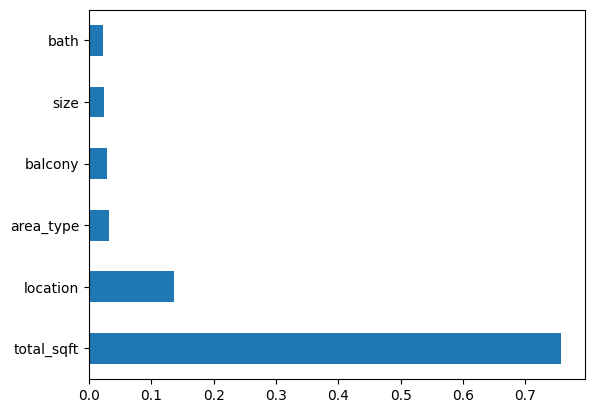

In [34]:
import matplotlib.pyplot as plt

feat_imp = pd.Series(best_rf.feature_importances_, index=X.columns)
feat_imp.nlargest(10).plot(kind='barh')
plt.show()


In [35]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Predict on test data
y_pred = best_rf.predict(X_test)

# Print accuracy metrics
print("✅ R2 Score:", r2_score(y_test, y_pred))
print("✅ RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))


✅ R2 Score: 0.6633219988858894
✅ RMSE: 0.24244173201811242


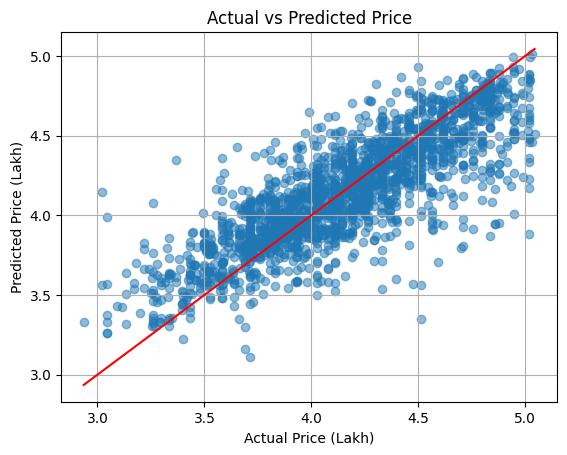

In [36]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Price (Lakh)")
plt.ylabel("Predicted Price (Lakh)")
plt.title("Actual vs Predicted Price")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r')
plt.grid(True)
plt.show()


In [37]:
# Before training
X = df.drop("price", axis=1)
y = df["price"]

# Save the column order used
import pickle
columns_used = X.columns.tolist()
with open("columns.pkl", "wb") as f:
    pickle.dump(columns_used, f)

# Train the model
model = RandomForestRegressor()
model.fit(X, y)

# Save model
with open("model.pkl", "wb") as f:
    pickle.dump(model, f)



In [38]:
# import pandas as pd
# import numpy as np
# import pickle

# # Load your cleaned dataset
# df = pd.read_csv('Bengaluru_House_Data.csv')  # Replace with your actual CSV

# # Optional: Log transform price for training model
# df['price'] = np.log1p(df['price'])  # if your model uses log1p(price)

# # Save the DataFrame for Flask usage (trend, structure, etc.)
# with open('df.pkl', 'wb') as f:
#     pickle.dump(df, f)

# print("✅ df.pkl file has been created.")
